In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import datetime
from sklearn.model_selection import train_test_split

import torch
import re
import os
import shutil
import glob
import zipfile
import cv2

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print('device :', device)
print('Current :', torch.cuda.current_device())
print('Count :', torch.cuda.device_count())

device : cuda
Current : 0
Count : 1


In [3]:
data = pd.read_csv('골밀도 데이터/total_data.csv')
data.head()

,Group,등록번호,생년월일,성별,진료의,검사 시 나이,신장,체중,BMI,처방일자,시행일자,BA 1,BA 2,Unnamed: 14,No,boneage
0,1698,8255049,2007-08-03,F,1,9.969863,129.5,26.9,16.1,2017-01-09,2017-07-20,9.75,9.75,NaN,1.jpg,9.750
1,1897,8537405,2008-08-22,F,1,9.989041,132.0,31.0,17.8,2018-02-28,2018-08-16,10.50,11.00,NaN,2.jpg,10.750
2,1422,7942635,2005-01-19,F,1,10.008219,136.4,33.2,17.9,2015-01-20,2015-01-20,11.00,11.25,NaN,3.jpg,11.125
3,1475,7995857,2005-02-09,F,1,10.049315,133.5,31.2,17.6,2015-02-25,2015-02-25,10.00,10.25,NaN,4.jpg,10.125
4,1888,8520261,2008-09-11,F,1,10.060274,130.6,23.7,13.9,2018-10-01,2018-10-01,10.00,9.75,NaN,5.jpg,9.875


## 학습데이터 생성

In [4]:
def optimize_img(r1,r2,r3,r4):
    tmp_binary_img = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) #CLAHE 생성
    for img in [r1,r2,r3,r4]:
        if img is not None:
            # resized_img = cv2.resize(img,(1000,400)) # (400, 500)
            blured_img = cv2.GaussianBlur(img,(5,5),0)            
            clahed_img = clahe.apply(blured_img)          #CLAHE 적용
            # _,binary_img = cv2.threshold(clahed_img,clahed_img.mean()*1.25,255,cv2.THRESH_BINARY)
            
            target_length = 500
            (original_height, original_width) = clahed_img.shape
            # 가로세로 비율을 유지하면서 긴 부분을 target_length로 조정합니다.
            if original_width > original_height:
                # 가로가 길 경우
                new_width = target_length
                new_height = int((new_width / original_width) * original_height)
            else:
                # 세로가 길 경우
                new_height = target_length
                new_width = int((new_height / original_height) * original_width)

            # 이미지 크기 조정
            resized_image = cv2.resize(clahed_img, (new_width, new_height))
            
            # 최종 이미지 크기
            target_size = 600
            old_size = resized_image.shape

            # 새로운 이미지 생성 (검은색 배경)
            new_image = np.zeros((target_size, target_size), dtype=np.uint8)

            # 이미지 중앙에 배치하기 위한 좌표 계산
            start_x = (target_size - old_size[1]) // 2
            start_y = (target_size - old_size[0]) // 2

            # 원본 이미지를 중앙에 배치
            new_image[start_y:start_y+old_size[0], start_x:start_x+old_size[1]] = resized_image
            
            tmp_binary_img.append(new_image)
                
    return np.array(tmp_binary_img)

In [5]:
def crop_img(img, roi_1, roi_2, roi_3, roi_4):
    
    cropped_roi_1_img = img[roi_1[0][1]:roi_1[1][1],roi_1[0][0]:roi_1[1][0]]
    cropped_roi_2_img = img[roi_2[0][1]:roi_2[1][1],roi_2[0][0]:roi_2[1][0]]
    cropped_roi_3_img = img[roi_3[0][1]:roi_3[1][1],roi_3[0][0]:roi_3[1][0]]
    cropped_roi_4_img = img[roi_4[0][1]:roi_4[1][1],roi_4[0][0]:roi_4[1][0]]

    optimzed_imgs = optimize_img(cropped_roi_1_img, cropped_roi_2_img, cropped_roi_3_img, cropped_roi_4_img)
    return optimzed_imgs

data augmentation - rotation + noise

In [6]:
X_data, y_data = [], []
X_aug_rot, y_aug_rot = [], []
X_aug_noise, y_aug_noise = [], []

for k in range(len(data)):
    if k == 354 or k == 355 or k == 916:
        continue
    img0 = cv2.imread('골밀도 데이터/rotate_image/' + data.No[k], cv2.IMREAD_GRAYSCALE)

    # 이미지 thresholding
    r_img = np.copy(img0)
    height, width = img0.shape
    img = img0[0:(int)(height*0.9),0:(int)(width*0.95)]
    ret, img = cv2.threshold(img, img0.mean(), 255, cv2.THRESH_BINARY)

    # 이미지 contouring
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    max_cnt = max(contours, key = cv2.contourArea)
    mask = np.zeros(img.shape, dtype= np.uint8)
    cv2.drawContours(mask, [max_cnt], -1, (255, 255, 255), -1)

    # 볼록한 점 구하기
    hull = cv2.convexHull(max_cnt, returnPoints= False)
    hull1 = cv2.convexHull(max_cnt)

    # 오목한 지점 구하기
    defects = cv2.convexityDefects(max_cnt, hull) # 인덱스로 반환

    # 거리를 저장할 수 있는 공간 생성
    di = []

    for index in range(defects.shape[0]):
        # 시작점, 끝점, far 점, 거리 할당
        sp, ep, fp, distance = defects[index, 0]
        
        # 거리 저장
        di.append(distance)

    far_xrange = []
    far_yrange = []
    start_xrange = []
    start_yrange = []

    # 가장 오목하게 들어가 있는 부분을 찾기 위해 sorting(내림차순)
    di = np.array(di)
    s_di = np.sort(di)[::-1]

    # 내림차순된 거리들을 6개만 뽑아내기 위해 slice
    for i in list(s_di[:6]):
        index = np.where(di == i)[0][0]
        
        sp, ep, fp, _ = defects[index, 0]
        
        far_xrange.append(max_cnt[fp][0][0])
        far_yrange.append(max_cnt[fp][0][1])
        
        start_xrange.append(max_cnt[sp][0][0])
        start_yrange.append(max_cnt[sp][0][1])
        

    #손목뼈 ROI
    carpus_sp = ((int)(min(far_xrange[4:6])*0.90),(int)(max(far_yrange[4:6])*0.90))
    carpus_ep = (int(max(far_xrange[4:6])*1.05),(int)(max(far_yrange[4:6])*1.15))

    #손목뼈 위쪽에 있는 관절 4개를 추출
    four_sp = ((int)(min(far_xrange[0:4])*0.70),int(min(far_yrange[0:4])*0.95))
    four_ep = (int(max(far_xrange[0:4])*1.05),(int)(max(far_yrange[0:4])*1.05))

    #중지 ROI 추출
    #중지 끝 좌표 구하기
    for y,x_r in enumerate(mask) :
        if 255 in x_r:
            #y에 따른 x rows 중 255인 x값 추출
            x_255_indexs = np.where(x_r == 255)[0]

            #255인 x값들 중 median 추출
            x_255_mid_index = x_255_indexs[(int)(len(x_255_indexs)/2)]
            first_255_x_point = x_255_mid_index

            first_255_y_point = y
            break
        
    ## 중지 끝 좌표에서 처음 오목한 곳의 x 좌표를 뺀 간격만큼
    sub = min(abs(first_255_x_point - far_xrange[0]), abs(first_255_x_point - far_xrange[1]))
    middle_finger_sp = (int((first_255_x_point - sub*1.5)), int(first_255_y_point*0.85))
    middle_finger_ep = (int((first_255_x_point + sub*1.5)), int(far_yrange[0]*1.05))

    #엄지손가락 좌표
    thumb_sp = (int(max(far_xrange[0:4])*1.05), int(start_yrange[start_xrange.index(max(start_xrange))]*0.95))
    thumb_ep = (int(max(start_xrange)*1.05), int(max(far_yrange)*0.9))
    
    optimized_imgs = crop_img(img0,(carpus_sp,carpus_ep), (four_sp, four_ep), (middle_finger_sp,middle_finger_ep), (thumb_sp, thumb_ep))
    
    row1 = np.vstack((optimized_imgs[0], optimized_imgs[1]))
    row2 = np.vstack((optimized_imgs[2], optimized_imgs[3]))

    combined_image = np.hstack((row1, row2))
    combined_image = cv2.resize(combined_image, (256, 256))

    X_data.append(combined_image)
    y_data.append(data.boneage[k])
    
    # data augmentation - rotation
    aug_rot_img = []
    angle = np.random.randint(0, 90)
    for crop_image in optimized_imgs:
        # 이미지 중심을 계산
        center = (crop_image.shape[1] // 2, crop_image.shape[0] // 2)
        rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)

        # 회전된 이미지의 경계가 잘리지 않도록 출력 이미지의 크기 조정
        cos = np.abs(rotation_matrix[0, 0])
        sin = np.abs(rotation_matrix[0, 1])

        # 새로운 경계 차원 계산
        new_width = int((crop_image.shape[0] * sin) + (crop_image.shape[1] * cos))
        new_height = int((crop_image.shape[0] * cos) + (crop_image.shape[1] * sin))

        # 변환 행렬의 이동 부분 조정
        rotation_matrix[0, 2] += (new_width / 2) - center[0]
        rotation_matrix[1, 2] += (new_height / 2) - center[1]

        # 회전된 이미지 얻기
        rotated_img = cv2.warpAffine(crop_image, rotation_matrix, (new_width, new_height))
        rotated_img = cv2.resize(rotated_img, (600, 600))
        aug_rot_img.append(rotated_img)
        
    row1 = np.vstack((aug_rot_img[0], aug_rot_img[1]))
    row2 = np.vstack((aug_rot_img[2], aug_rot_img[3]))

    combined_image_rot = np.hstack((row1, row2))
    combined_image_rot = cv2.resize(combined_image_rot, (256, 256))
    
    X_aug_rot.append(combined_image_rot)
    y_aug_rot.append(data.boneage[k])
    
    # data augmentation - add noise
    aug_noise_img = []
    sigma = np.random.randint(10, 50)
    for crop_image in optimized_imgs:
        row, col = crop_image.shape
        
        # 노이즈 강도 조정
        gaussian = np.random.normal(0, sigma, (row, col))
        
        # 노이즈 추가된 이미지 얻기
        noisy_image = np.clip(crop_image + gaussian, 0, 255)
        aug_noise_img.append(noisy_image)
        
    row1 = np.vstack((aug_noise_img[0], aug_noise_img[1]))
    row2 = np.vstack((aug_noise_img[2], aug_noise_img[3]))

    combined_image_noise = np.hstack((row1, row2))
    combined_image_noise = cv2.resize(combined_image_noise, (256, 256))
    
    X_aug_noise.append(combined_image_noise)
    y_aug_noise.append(data.boneage[k])
    
X_data, y_data = np.array(X_data), np.array(y_data)
X_aug_rot, y_aug_rot = np.array(X_aug_rot), np.array(y_aug_rot)
X_aug_noise, y_aug_noise = np.array(X_aug_noise), np.array(y_aug_noise)

### CNN 모델 생성 - Attention-Xception
https://www.researchgate.net/publication/351221264_Intelligent_Bone_Age_Assessment_An_Automated_System_to_Detect_a_Bone_Growth_Problem_Using_Convolutional_Neural_Networks_with_Attention_Mechanism

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import torch

In [8]:
#separable 합성곱 함수
def separable_conv(x, inchannel,outchannel):
  x = keras.layers.Conv2D(inchannel, (3,3), strides=1, padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Conv2D(outchannel, (1,1), strides=1, padding="same")(x)
  x = keras.layers.BatchNormalization()(x)
  return x

In [9]:
#resiual_units 함수 
def resiual_units(input_x):
  x = keras.layers.ReLU()(input_x)
  x = separable_conv(x,x.shape[-1],128)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.ReLU()(x)
  x = separable_conv(x,x.shape[-1],256)
  x = keras.layers.BatchNormalization()(x)

  x = keras.layers.ReLU()(x)
  x = separable_conv(x,x.shape[-1],512)
  x = keras.layers.BatchNormalization()(x)
  
  input_x = keras.layers.Add()([x,input_x])

  return input_x

In [10]:
#model middle_flow 함수
def middle_flow(input_x):
  #encoder
  x = keras.layers.MaxPool2D((2,2),padding="same")(input_x)
  x = resiual_units(x)
  x = keras.layers.MaxPool2D((2,2),padding="same")(x)
  x = resiual_units(x)
  x = keras.layers.MaxPool2D((2,2),padding="same")(x)
  x = resiual_units(x)
  
  #decoder
  x = resiual_units(x)
  x = keras.layers.UpSampling2D((2,2),interpolation='bilinear')(x)
  x = resiual_units(x)
  x = keras.layers.UpSampling2D((2,2),interpolation='bilinear')(x)
  x = resiual_units(x)
  x = keras.layers.UpSampling2D((2,2),interpolation='bilinear')(x)
  
  x = separable_conv(x,x.shape[-1],512)
  x = separable_conv(x,x.shape[-1],512) 
  
  #sigmoid 
  x = keras.activations.sigmoid(x)
  x = keras.layers.Multiply()([input_x,x])
  x = keras.layers.Add()([input_x,x])

  x = resiual_units(x)

  return x

In [24]:
#골연령 측정 모델
# entry flow model
input = keras.Input(shape=(256,256,1))
x = keras.layers.Conv2D(32, (3,3), strides = 2)(input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

x = keras.layers.Conv2D(64, (3,3), strides=1)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

#첫번째
x1 = keras.layers.Conv2D(128,(1,1),strides=2)(x) 
x1 = keras.layers.BatchNormalization()(x1)

x = separable_conv(x,x.shape[-1],128)
x = keras.layers.ReLU()(x)

x = separable_conv(x,x.shape[-1],128)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D((2,2),2,padding="same")(x)

x = keras.layers.Add()([x,x1])

#2번째
x1 = keras.layers.Conv2D(512,(1,1),strides=2)(x)
x1 = keras.layers.BatchNormalization()(x1)

x = separable_conv(x,x.shape[-1],512)
x = keras.layers.ReLU()(x)

x = separable_conv(x,x.shape[-1],512)
x = keras.layers.ReLU()(x)
x = keras.layers.MaxPool2D((2,2),2,padding="same")(x)

x = keras.layers.Add()([x,x1])


#middle flow model
x = middle_flow(x)


#exit flow model
x1 = keras.layers.Conv2D(1024,(1,1),strides=2)(x)

x = keras.layers.ReLU()(x)
x = separable_conv(x,x.shape[-1],728)
x = keras.layers.ReLU()(x)
x = separable_conv(x,x.shape[-1],1024)
x = keras.layers.MaxPool2D((2,2),2,padding="same")(x)

x = keras.layers.Add()([x,x1])


x = separable_conv(x,x.shape[-1],1536)
x = keras.layers.ReLU()(x)
x = separable_conv(x,x.shape[-1],2048)
x = keras.layers.ReLU()(x)

x = keras.layers.GlobalAvgPool2D()(x)

x = keras.layers.Dense(1000,activation='relu')(x)
x = keras.layers.Dense(256,activation='relu')(x)
x = keras.layers.Dense(1)(x)

model = keras.models.Model(input,x)
model.compile(optimizer='adam', loss='mae', metrics=['mae','mse'], run_eagerly=True)

In [25]:
model.save('./tjnet_model.h5')

In [26]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_134 (Conv2D)         (None, 127, 127, 32)         320       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_174 (B  (None, 127, 127, 32)         128       ['conv2d_134[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 re_lu_62 (ReLU)             (None, 127, 127, 32)         0         ['batch_normalization_17

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_data.reshape(1234, 256, 256, 1), 
                                                    y_data, random_state=42, test_size=0.2)

X_rot_train, X_rot_test, y_rot_train, y_rot_test = train_test_split(X_aug_rot.reshape(1234, 256, 256, 1), 
                                                                    y_data, random_state=42, test_size=0.2)

X_noise_train, X_noise_test, y_noise_train, y_noise_test = train_test_split(X_aug_noise.reshape(1234, 256, 256, 1), 
                                                                            y_data, random_state=42, test_size=0.2)

In [15]:
X_aug_data = np.concatenate((X_train, X_rot_train, X_noise_train), axis = 0)
y_aug_data = np.concatenate((y_train, y_rot_train, y_noise_train), axis = 0)

X_aug_train, X_aug_val, y_aug_train, y_aug_val = train_test_split(X_aug_data, y_aug_data, random_state=42, test_size = 0.2)

In [27]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint

filename = 'checkpoint-150-epochs-8-batchs.h5'
checkpoint = ModelCheckpoint(filename, mointor='val_loss', verbose=1, 
                             save_best_only = True, mode='auto')

In [ ]:
from keras.models import load_model
model = load_model('./checkpoint-150-epochs-8-batchs.h5')

In [28]:
model.fit(X_aug_train, y_aug_train, batch_size=8, epochs=150, callbacks=checkpoint, validation_data=(X_aug_val, y_aug_val))

Epoch 1/150
296/296 [==============================] - ETA: 0s - loss: 2.8352 - mae: 2.8352 - mse: 13.3426
Epoch 1: val_loss improved from inf to 139.42503, saving model to checkpoint-150-epochs-8-batchs.h5
296/296 [==============================] - 175s 502ms/step - loss: 2.8352 - mae: 2.8352 - mse: 13.3426 - val_loss: 139.4250 - val_mae: 139.4250 - val_mse: 20649.1660
Epoch 2/150
296/296 [==============================] - ETA: 0s - loss: 2.0309 - mae: 2.0309 - mse: 6.7201
Epoch 2: val_loss improved from 139.42503 to 90.09615, saving model to checkpoint-150-epochs-8-batchs.h5
296/296 [==============================] - 145s 491ms/step - loss: 2.0309 - mae: 2.0309 - mse: 6.7201 - val_loss: 90.0962 - val_mae: 90.0962 - val_mse: 9055.1084
Epoch 3/150
296/296 [==============================] - ETA: 0s - loss: 1.8305 - mae: 1.8305 - mse: 5.5201
Epoch 3: val_loss improved from 90.09615 to 22.76268, saving model to checkpoint-150-epochs-8-batchs.h5
296/296 [==============================] - 1

In [29]:
test_prediction = model.predict(X_test)

8/8 [==============================] - 17s 1s/step


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('mae : {:.3f}'.format(mean_absolute_error(test_prediction, y_test)))
print('rmse : {:.3f}'.format(np.sqrt(mean_squared_error(test_prediction, y_test))))

mae : 0.785
rmse : 1.063


## Result

batchsize : 16
+ crop 이미지 이진화 처리를 안했을 때 mae : 1.139, rmse : 1.422
+ crop 이미지 이진화 처리를 했을 때 mae : 1.880, rmse : 2.354
+ 앞으로 이진화 처리를 안하고 진행

batchsize : 8
+ mae : 1.111, rmse : 1.400 
+ 시간이 오래걸리지만 배치사이즈를 8로 하는게 더 정확함

data augmentation
+ 원본:회전:노이즈 = 1:1:1
+ mae : 0.785, rmse : 1.063

최종적으로 mae : 0.785 으로 약 9.43 months 오차발생

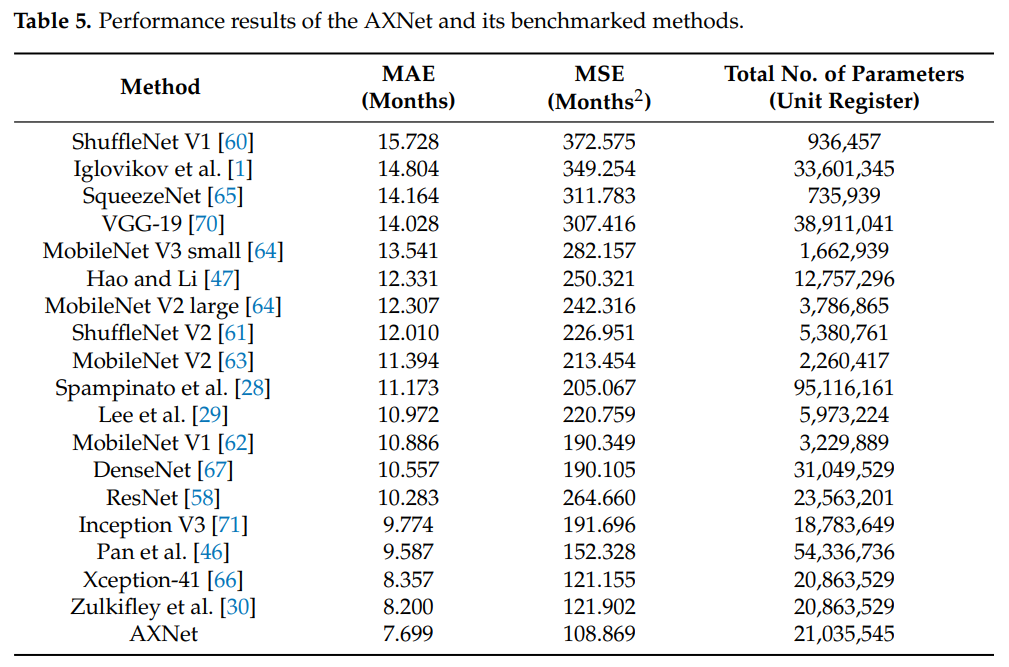